##### <p> Samuel Wolfe <br> November 718, 2023 <br> MSBA 207 <br> Chapter 14 </p>

In [61]:
# need to run "pip install mlxtend" first
# need to run "pip install surprise" first
# "conda install -c conda-forge scikit-surprise" in "terminal" (Mac) or "Anaconda Prompt" (Windows)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import clear_output

from pathlib import Path

import heapq
from collections import defaultdict

import pandas as pd
pd.set_option('display.width', 250)
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [62]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('E:/Aliit/School/MSBA/206/MSBA-206/dmba/instacart')
#DATA = Path('C:/Users/Min Li/OneDrive/teaching/DS110/dmba')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)
# Load and preprocess data set 

In [63]:
file1 = pd.read_csv(DATA / 'order_products__train.csv')
file2 = pd.read_csv(DATA / 'products.csv')

In [64]:
df_instacart = pd.merge(left=file2, right=file1,on='product_id')
df_instacart['product_name'] = df_instacart['product_name'].replace(' ','_',regex=True)
df_instacart

,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered
0,1,Chocolate_Sandwich_Cookies,61,19,6695,7,1
1,1,Chocolate_Sandwich_Cookies,61,19,48361,9,0
2,1,Chocolate_Sandwich_Cookies,61,19,63770,4,0
3,1,Chocolate_Sandwich_Cookies,61,19,75339,9,0
4,1,Chocolate_Sandwich_Cookies,61,19,240996,3,1
...,...,...,...,...,...,...,...
1384612,49687,Smartblend_Healthy_Metabolism_Dry_Cat_Food,41,8,1092104,1,0
1384613,49688,Fresh_Foaming_Cleanser,73,11,655800,10,1
1384614,49688,Fresh_Foaming_Cleanser,73,11,2198380,10,0
1384615,49688,Fresh_Foaming_Cleanser,73,11,2508423,3,0


In [65]:
df_instacart = df_instacart[['order_id','product_name']]

list_single_items = df_instacart.drop_duplicates(subset='order_id',keep=False)['order_id'].to_list()

In [66]:
#df_instacart_multi = df_instacart[~df_instacart['order_id'].isin(list_single_items)]
#df_instacart_multi

In [67]:
df_instacart.dtypes

order_id         int64
product_name    object
dtype: object

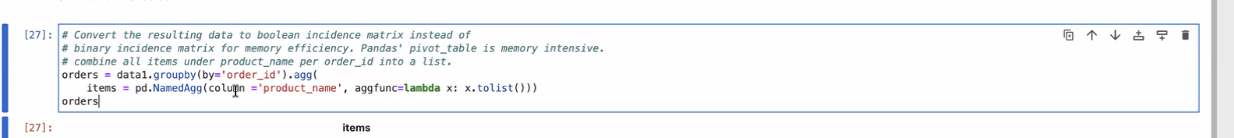

In [68]:
bin_cart = df_instacart.groupby(by='order_id').agg(items = pd.NamedAgg(column='product_name',aggfunc=lambda x: x.tolist()))

In [69]:
bin_cart

,items
order_id,
1,"[Organic_Celery_Hearts, Organic_4%_Milk_Fat_Wh..."
36,"[Spring_Water, Prosciutto,_Americano, Grated_P..."
38,"[Organic_Raw_Unfiltered_Apple_Cider_Vinegar, S..."
96,"[Roasted_Turkey, Organic_Whole_Strawberries, O..."
98,"[Organic_Whole_Grassmilk_Milk, Garbanzo_Beans,..."
...,...
3421049,"[Organic_Grated_Ginger, Organic_Whole_Grain_Wh..."
3421056,"[Total_Plain_Greek_Strained_Yogurt, Homestyle_..."
3421058,"[Extralean_Ground_Turkey_Breast, Club_Soda_Low..."


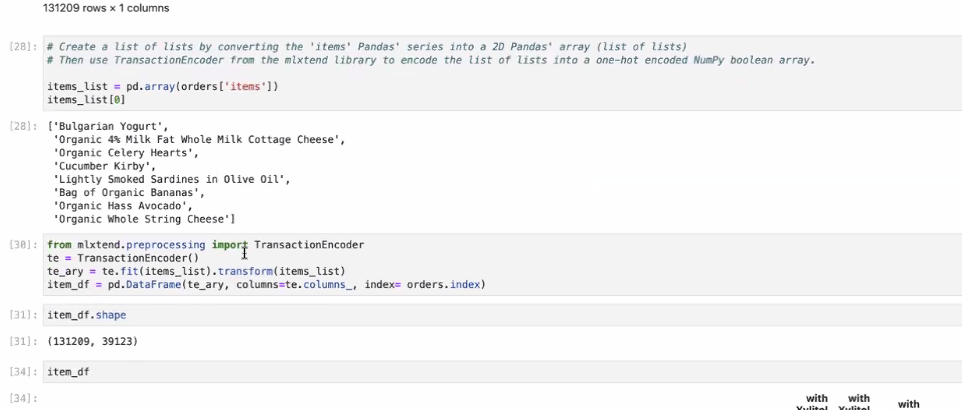

In [70]:
item_list = pd.array(bin_cart['items'])
item_list[0]

['Organic_Celery_Hearts',
 'Organic_4%_Milk_Fat_Whole_Milk_Cottage_Cheese',
 'Bag_of_Organic_Bananas',
 'Organic_Whole_String_Cheese',
 'Lightly_Smoked_Sardines_in_Olive_Oil',
 'Organic_Hass_Avocado',
 'Bulgarian_Yogurt',
 'Cucumber_Kirby']

In [71]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(item_list).transform(item_list)
item_df = pd.DataFrame(te_ary, columns=te.columns_, index = bin_cart.index)

In [72]:
item_df

,#2_Coffee_Filters,#2_Cone_White_Coffee_Filters,#2_Mechanical_Pencils,#4_Natural_Brown_Coffee_Filters,&_Go!_Hazelnut_Spread_+_Pretzel_Sticks,+Energy_Black_Cherry_Vegetable_&_Fruit_Juice,0%_Fat_Black_Cherry_Greek_Yogurt_y,0%_Fat_Blueberry_Greek_Yogurt,0%_Fat_Free_Organic_Milk,0%_Fat_Greek_Yogurt_Black_Cherry_on_the_Bottom,...,with_Sweet_Cinnamon_Bunches_Cereal,with_Xylitol_Cinnamon_18_Sticks_Sugar_Free_Gum,with_Xylitol_Island_Berry_Lime_18_Sticks_Sugar_Free_Gum,with_Xylitol_Minty_Sweet_Twist_18_Sticks_Sugar_Free_Gum,with_Xylitol_Original_Flavor_18_Sticks_Sugar_Free_Gum,with_Xylitol_Unwrapped_Original_Flavor_50_Sticks_Sugar_Free_Gum,with_Xylitol_Unwrapped_Spearmint_50_Sticks_Sugar_Free_Gum,with_Xylitol_Watermelon_Twist_18_Sticks_Sugar_Free_Gum,with_a_Splash_of_Mango_Coconut_Water,with_a_Splash_of_Pineapple_Coconut_Water
order_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421049,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421056,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3421058,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#binary_instacart = df_instacart.pivot_table(index='order_id',columns='product_name',values='product_id',fill_value=0,aggfunc='nunique')

In [ ]:
#binary_instacart

In [74]:
# create frequent itemsets
itemsets = apriori(item_df, min_support=0.004, use_colnames=True)
itemsets

,support,itemsets
0,0.009893,(100%_Raw_Coconut_Water)
1,0.009016,(100%_Recycled_Paper_Towels)
2,0.017514,(100%_Whole_Wheat_Bread)
3,0.004207,(100_Calorie__Per_Bag_Popcorn)
4,0.004382,(2%_Reduced_Fat_DHA_Omega-3_Reduced_Fat_Milk)
...,...,...
528,0.004138,"(Strawberries, Seedless_Red_Grapes)"
529,0.004474,"(Organic_Baby_Spinach, Organic_Strawberries, B..."
530,0.004047,"(Organic_Raspberries, Organic_Hass_Avocado, Ba..."
531,0.005411,"(Organic_Hass_Avocado, Organic_Strawberries, B..."


In [75]:
# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.01)

In [76]:
rules.sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
181,(Bunched_Cilantro),(Limes),0.014633,0.045980,0.004253,0.290625,6.320672,0.003580,1.344874,0.854290
180,(Limes),(Bunched_Cilantro),0.045980,0.014633,0.004253,0.092491,6.320672,0.003580,1.085793,0.882360
189,(Jalapeno_Peppers),(Limes),0.014473,0.045980,0.004169,0.288046,6.264590,0.003503,1.340003,0.852714
188,(Limes),(Jalapeno_Peppers),0.045980,0.014473,0.004169,0.090668,6.264590,0.003503,1.083792,0.880875
321,(Organic_Garlic),(Organic_Yellow_Onion),0.031690,0.032696,0.006478,0.204425,6.252314,0.005442,1.215856,0.867552
...,...,...,...,...,...,...,...,...,...,...
20,(Large_Lemon),(Bag_of_Organic_Bananas),0.062000,0.117980,0.008056,0.129932,1.101311,0.000741,1.013738,0.098072
94,(Strawberries),(Bag_of_Organic_Bananas),0.049494,0.117980,0.005922,0.119649,1.014148,0.000083,1.001896,0.014677
95,(Bag_of_Organic_Bananas),(Strawberries),0.117980,0.049494,0.005922,0.050194,1.014148,0.000083,1.000737,0.015817
143,(Banana),(Organic_Hass_Avocado),0.142719,0.055583,0.007217,0.050571,0.909834,-0.000715,0.994721,-0.103621


In [77]:
sup_mean = rules.describe()['support'][1]
rules_best_sup = rules.loc[rules['support'] >= sup_mean].sort_values(by=['lift'], ascending=False)
rules_best_sup_no_lap = rules_best_sup.drop(index=rules_best_sup.index[::2])
rules_best_sup_no_lap.head(10).drop(columns=['antecedent support','consequent support','conviction','zhangs_metric'])

,antecedents,consequents,support,confidence,lift,leverage
320,(Organic_Yellow_Onion),(Organic_Garlic),0.006478,0.198135,6.252314,0.005442
220,(Limes),(Organic_Cilantro),0.007675,0.166915,6.211228,0.006439
190,(Limes),(Large_Lemon),0.012156,0.264379,4.264159,0.009305
340,(Organic_Raspberries),(Organic_Strawberries),0.012728,0.301118,3.626710,0.009218
327,(Organic_Hass_Avocado),(Organic_Raspberries),0.007766,0.139723,3.305611,0.005417
307,(Organic_Cucumber),(Organic_Hass_Avocado),0.006333,0.180143,3.240970,0.004379
296,(Organic_Strawberries),(Organic_Blueberries),0.009672,0.116486,3.077735,0.006529
216,(Limes),(Organic_Avocado),0.007903,0.171888,3.044034,0.005307
270,(Organic_Baby_Spinach),(Organic_Grape_Tomatoes),0.006463,0.086672,2.974670,0.004290
193,(Large_Lemon),(Organic_Avocado),0.010281,0.165827,2.936692,0.006780


#### In order to make it a bit more interesting, I removed every other entry, otherwise we would really only be comparing 5 different combos.
#### Looking at the items, the sequence is the same. The support value is how likely the collection of antecedents and consequents are to appear in the dataset. Then we have confidence, which is, given the antecedent, the consequent has a chance that the item in the rhs value will be in the cart given the lhs item. The higher the confidence, the higher this chance. Then we have lift, which is a representation of the strength of item association in the given dataset. Given all of these rules have lifts over 1.0, we can safely assume they are all associated at least a little bit. Finally we have leverage, which is a range of -1,0,1. Where the closer to 0 for the value the more independent the items are. Negative means they are less likely to associate together, positive indicates they are more likely associate together.
#### All of these items are grocery based, so we can see some common pairings. Garlic and onion, both organic. Limes and cilantro, interestingly the limes do not appear to have an organic label. Lemon and limes. Its all various pairings of these common fruits and vegetables.
#### Looking at their support value, I am rather shocked at how low this number is overall for the rules. I would have expected a much higher value for this column. Confidence is also low. Lift is healthy. Leverage is low as well.
#### I think grocery items like these must suffer from what I like to call "commonality". They are the bare bones most common additives to home cooking, thus they will likely be in a lot of carts. Thus suggesting to someone who has Organic Garlic in their cart if they would like to add Organic Yellow Onion is a fairly safe move.